In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
from tqdm.notebook import tqdm

In [4]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
project_name = 'FlowerDoc'

In [6]:
data ='/content/drive/MyDrive/Dataset Rose'
os.listdir(data)

['Dataset Rose']

In [7]:
os.listdir(data+'/Dataset Rose/')

['Train', 'Valid']

In [8]:
os.listdir(data+'/Dataset Rose/Train/')

['RoseCrownGall',
 'FreshLeaf',
 'RoseBotrytis',
 'RoseDying',
 'DownyMildew',
 'BlackSpot']

In [9]:
unique_diseases = []
cl = os.listdir(data+'/Dataset Rose/Train/')
for i in cl:
    x = i.split(' ')
    if x[0] not in unique_diseases:
        unique_diseases.append(x[0])
print("Number of Unique Dieases: ",len(unique_diseases))
print("Unique Diseases: ",unique_diseases)

Number of Unique Dieases:  6
Unique Diseases:  ['RoseCrownGall', 'FreshLeaf', 'RoseBotrytis', 'RoseDying', 'DownyMildew', 'BlackSpot']


In [10]:
transform = transforms.Compose(
    [transforms.Resize(size = 128),
     transforms.ToTensor()])
dataset = ImageFolder(data+'/Dataset Rose/Train/',transform=transform)
test_ds = ImageFolder(data+'/Dataset Rose/Valid/',transform=transform)
print("Number of training images: ",len(dataset))
print("Number of testing images: ",len(test_ds))

Number of training images:  1621
Number of testing images:  802


In [11]:
num_classes = dataset.classes
print("Number of classes: ",len(num_classes))
print(num_classes)

Number of classes:  6
['BlackSpot', 'DownyMildew', 'FreshLeaf', 'RoseBotrytis', 'RoseCrownGall', 'RoseDying']


In [12]:
image, label  = dataset[1000]
print("Image shape:",image.shape)
print("Image Label: ",label)
print("Image Label: ",dataset.classes[label])
print(image)

Image shape: torch.Size([3, 128, 128])
Image Label:  3
Image Label:  RoseBotrytis
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0078, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0039, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0039, 0.0118,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0078],
         ...,
         [0.0078, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0

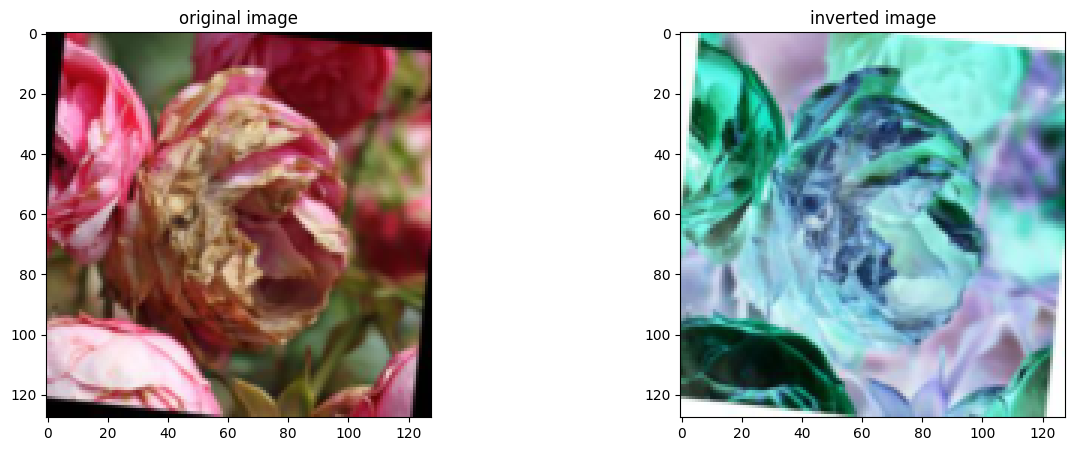

In [16]:
image, label  = dataset[973]
fig,(ax1,ax2) = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
ax1.imshow(image.permute(1,2,0))
ax1.set_title("original image")
ax2.imshow(1-image.permute(1,2,0))
ax2.set_title("inverted image")
plt.show()

In [14]:
random_seed = 42
torch.manual_seed(random_seed)

In [15]:
validation_split = 0.3
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [ ]:
batch_size = 16

train_loader = DataLoader(train_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss

    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss':loss,'val_acc':acc}

    def validation_epoch_end(self,outputs):
        batch_loss = [out['val_loss'] for out in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [out['val_acc'] for out in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class Plant_Disease_Model(ImageClassificationBase):
  
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #output : 64*64*64

            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #output : 128*32*32

            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #output : 256*16*16

            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #output : 512*8*8

            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #output : 1024*4*4
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,38)
            )

    def forward(self,xb):
        out = self.network(xb)
        return out

In [ ]:
class Plant_Disease_Model1(ImageClassificationBase):
  
    def __init__(self):
        super().__init__()
        self.network = models.vgg16(pretrained=True)
        num_ftrs = self.network.classifier[-1].in_features
        self.network.classifier[-1] = nn.Linear(num_ftrs, 38)

    def forward(self,xb):
        out = self.network(xb)
        return out

In [ ]:
class Plant_Disease_Model2(ImageClassificationBase):
  
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 38)

    def forward(self,xb):
        out = self.network(xb)
        return out

In [ ]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
model = to_device(Plant_Disease_Model2(), device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 208MB/s]


In [ ]:
model

Plant_Disease_Model2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
evaluate(model,val_loader)

{'val_loss': 3.8533201217651367, 'val_acc': 0.05981183052062988}

In [ ]:
history = fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.7582, val_loss: 0.8265, val_acc: 0.8065


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.3756, val_loss: 0.3714, val_acc: 0.8810


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.3149, val_loss: 0.0945, val_acc: 0.9718


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.3316, val_loss: 0.1259, val_acc: 0.9556


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.1374, val_loss: 0.2872, val_acc: 0.9254


In [ ]:
def plot_lossess(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Val acc')
    plt.legend(['Training', 'Validation'])
    plt.title('val Acc vs. No. of epochs');

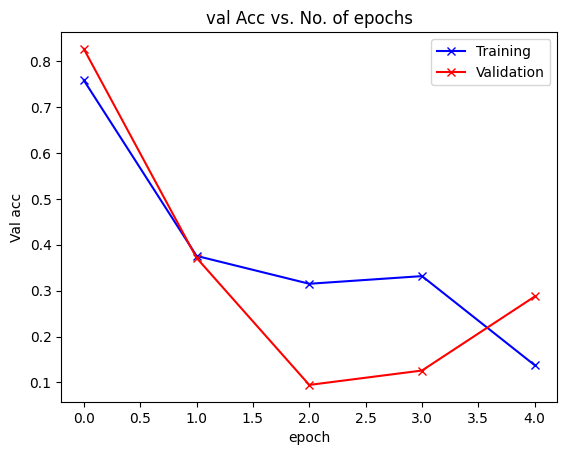

In [ ]:
plot_lossess(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

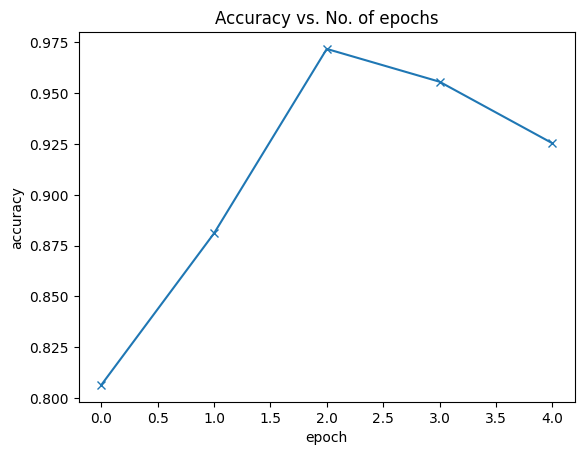

In [ ]:
plot_accuracies(history)

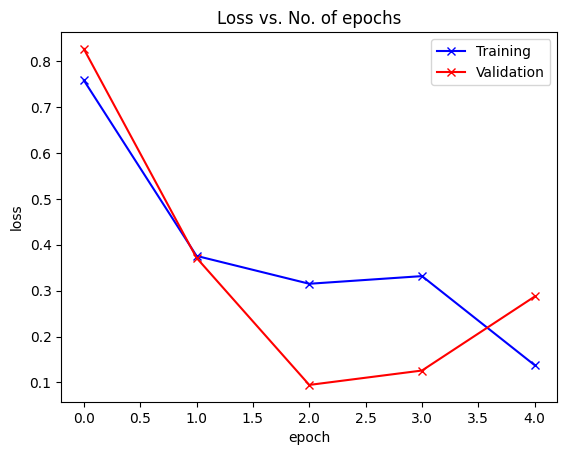

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model,val_loader)

{'val_loss': 0.28934988379478455, 'val_acc': 0.9254032373428345}

In [ ]:
x = evaluate(model,test_loader)
x

{'val_loss': 0.28754305839538574, 'val_acc': 0.9227941036224365}

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: BlackSpot , Predicted: BlackSpot


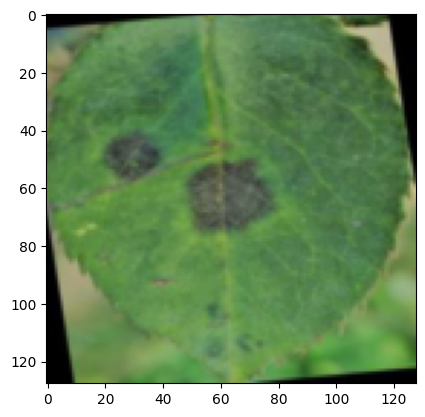

In [ ]:
img, label = test_ds[25]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: RoseBotrytis , Predicted: RoseBotrytis


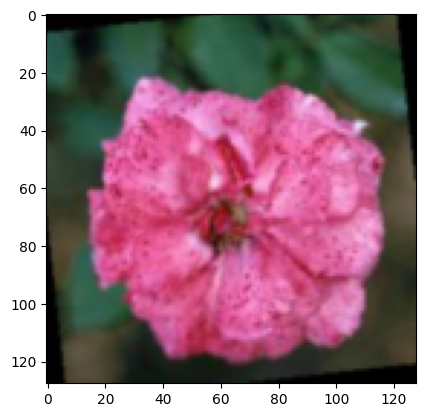

In [ ]:
img, label = test_ds[500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: FreshLeaf , Predicted: FreshLeaf


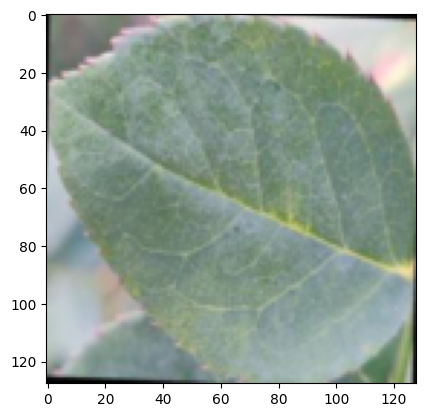

In [ ]:
img, label = test_ds[425]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: RoseBotrytis , Predicted: RoseBotrytis


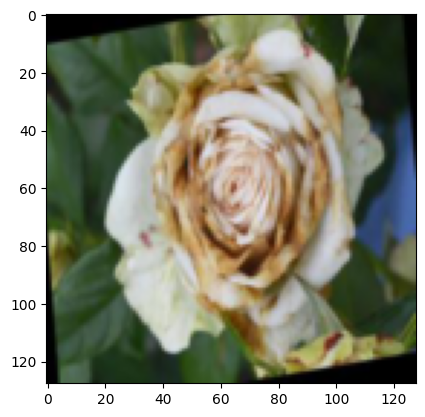

In [ ]:
img, label = test_ds[525]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
history = fit(10, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/71 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

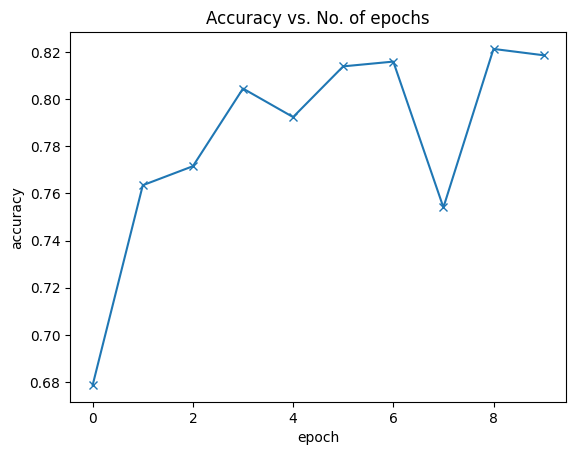

In [ ]:
plot_accuracies(history)

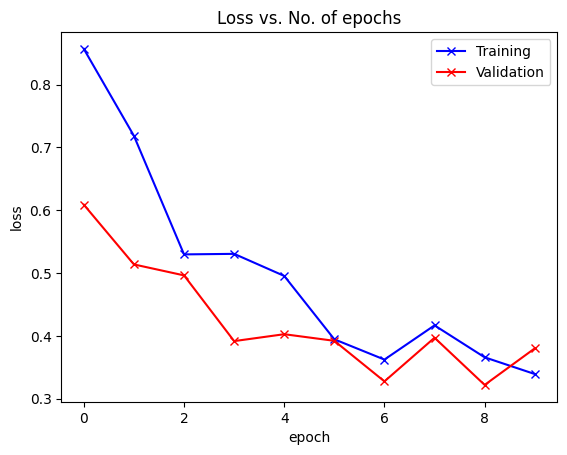

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model,val_loader)

{'val_loss': 0.3789142966270447, 'val_acc': 0.8185483813285828}

In [ ]:
history = fit(15, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.3412, val_loss: 0.2885, val_acc: 0.8784


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.2976, val_loss: 0.3248, val_acc: 0.8528


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.2900, val_loss: 0.2898, val_acc: 0.8522


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.2744, val_loss: 0.3289, val_acc: 0.8535


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3036, val_loss: 0.2772, val_acc: 0.8878


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.3559, val_loss: 0.3132, val_acc: 0.8750


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.2876, val_loss: 0.2985, val_acc: 0.8575


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.2543, val_loss: 0.3067, val_acc: 0.8649


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2705, val_loss: 0.4582, val_acc: 0.8394


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.2378, val_loss: 0.3641, val_acc: 0.8112


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.2285, val_loss: 0.2753, val_acc: 0.8609


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.2319, val_loss: 0.3171, val_acc: 0.8394


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.2242, val_loss: 0.2803, val_acc: 0.8495


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.1826, val_loss: 0.2664, val_acc: 0.9046


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.1999, val_loss: 0.2810, val_acc: 0.8656


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

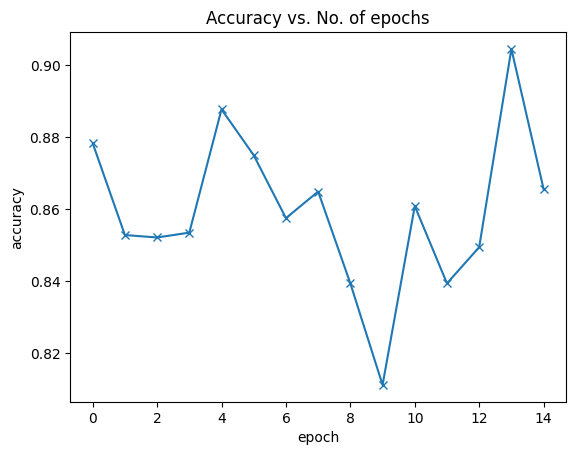

In [ ]:
plot_accuracies(history)

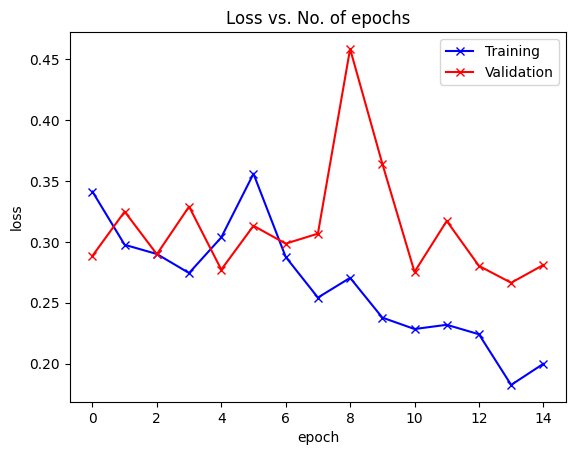

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model,val_loader)

{'val_loss': 0.2797565460205078, 'val_acc': 0.8655914068222046}

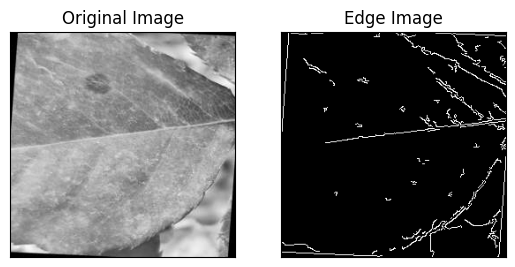

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('/content/drive/MyDrive/Dataset Rose/Dataset Rose/Train/BlackSpot/Black Spot (1).jpg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
torch.save(model.state_dict(), 'plantDisease-resnet34.pth')


AttributeError: ignored

In [ ]:
model.eval()

Plant_Disease_Model2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
!pip install onnx


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 49.9 MB/s eta 0:00:00


In [ ]:
!pip install onnx-tf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 29.0 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade onnx-tf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision

model = torchvision.models.resnet34(pretrained=True)

# define an example input tensor
example_input = torch.randn(2, 3, 256, 256)

# export the model to ONNX format
torch.onnx.export(model, example_input, 'plantDisease-resnet34.onnx')


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
import onnx

onnx_model = onnx.load('/content/plantDisease-resnet34.onnx')



In [27]:
import tensorflow as tf
from torch import onnx
model = Plant_Disease_Model()

# Convert the PyTorch model to a TensorFlow model
dummy_input = torch.randn(2, 3, 256, 256)
input_names = ['input']
output_names = ['output']
torch.onnx.export(model, dummy_input, 'model.onnx', input_names=input_names, output_names=output_names, opset_version=11)

# Convert the TensorFlow model to a TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model('model.onnx')
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [27]:
import torch.onnx
import onnx
import tensorflow as tf
from onnx_tf.backend import prepare

# Load the PyTorch model
model = Plant_Disease_Model()

# Export the model to ONNX format
dummy_input = torch.randn(1, 3, 128, 128)
input_names = ["input"]
output_names = ["output"]
onnx_model_path = "model.onnx"
torch.onnx.export(model, dummy_input, onnx_model_path, input_names=input_names, output_names=output_names)

# Convert the ONNX model to TensorFlow format
onnx_model = onnx.load(onnx_model_path)
tf_model = prepare(onnx_model)

# Convert the TensorFlow model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
tflite_model = converter.convert()

# Save the TFLite model to disk
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


In [27]:
from torch import onnx
model = Plant_Disease_Model2()
model.load_state_dict(torch.load('plantDisease-resnet34.pth'))
model.eval()

converter = tf.lite.TFLiteConverter.from_onnx('plantDisease-resnet34.onnx')
tflite_model = converter.convert()

with open('Plant_Disease_Model.tflite', 'wb') as f:
  f.write(tflite_model)



